# Assignment: Introduction to Machine Learning (CAT Assignment 1)
**Name:** Harini J

**Reg no:** 3122237001015

**Course:** ICS1502 - Introduction to Machine Learning

**Tasks:** Regression (Mobile Phone Price Prediction) and Linear Classification (Bank Note Authentication)  


Part-1 REGRESSION

In [1]:
# Cell 1: Imports and settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(style='whitegrid')
%matplotlib inline


In [6]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Load dataset from your Drive ---
import pandas as pd

mobile_path = '/content/drive/MyDrive/ML-THEO-ASS1/mob-pred-dataset/Cellphone.csv'  # update path if needed
mobile = pd.read_csv(mobile_path)

print("Mobile dataset shape:", mobile.shape)
print("First few rows:")
display(mobile.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mobile dataset shape: (161, 14)
First few rows:


,Product_id,Price,Sale,weight,resoloution,ppi,cpu core,cpu freq,internal mem,ram,RearCam,Front_Cam,battery,thickness
0,203,2357,10,135.0,5.2,424,8,1.35,16.0,3.000,13.00,8.0,2610,7.4
1,880,1749,10,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9
2,40,1916,10,110.0,4.7,312,4,1.20,8.0,1.500,13.00,5.0,2000,7.6
3,99,1315,11,118.5,4.0,233,2,1.30,4.0,0.512,3.15,0.0,1400,11.0
4,880,1749,11,125.0,4.0,233,2,1.30,4.0,1.000,3.15,0.0,1700,9.9


In [8]:
# Identify target column (price)
target_col = 'Price'   # <-- change if your dataset has a different column name
features = [c for c in mobile.columns if c != target_col]

X = mobile[features].select_dtypes(include=[np.number]).values
y = mobile[target_col].values

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (128, 13) Test shape: (33, 13)


In [9]:
def add_bias(X):
    return np.hstack([np.ones((X.shape[0],1)), X])

def normal_eqn(X, y, lmbda=0.0):
    n_features = X.shape[1]
    I = np.eye(n_features)
    I[0,0] = 0   # don't regularize bias term
    theta = np.linalg.pinv(X.T @ X + lmbda*I) @ X.T @ y
    return theta

def gradient_descent(X, y, alpha=1e-4, epochs=20000, lmbda=0.0):
    n, d = X.shape
    theta = np.zeros(d)
    for i in range(epochs):
        grad = (1/n) * (X.T @ (X @ theta - y)) + lmbda * theta
        theta -= alpha * grad
    return theta

def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2


In [11]:
# --- Standardize data for stable training ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_b = add_bias(X_train_scaled)
X_test_b = add_bias(X_test_scaled)

# --- 1) Closed-form solution (No regularization) ---
theta_cf = normal_eqn(X_train_b, y_train, lmbda=0.0)
y_pred_cf = X_test_b @ theta_cf
mse_cf, rmse_cf, r2_cf = metrics(y_test, y_pred_cf)

# --- 2) Gradient descent (No regularization) ---
theta_gd = gradient_descent(X_train_b, y_train, alpha=1e-5, epochs=20000, lmbda=0.0)
y_pred_gd = X_test_b @ theta_gd
mse_gd, rmse_gd, r2_gd = metrics(y_test, y_pred_gd)

print(f"\nClosed-form → MSE={mse_cf:.3f}, RMSE={rmse_cf:.3f}, R²={r2_cf:.3f}")
print(f"Gradient Descent → MSE={mse_gd:.3f}, RMSE={rmse_gd:.3f}, R²={r2_gd:.3f}")



Closed-form → MSE=23062.230, RMSE=151.863, R²=0.959
Gradient Descent → MSE=3434118.744, RMSE=1853.138, R²=-5.058


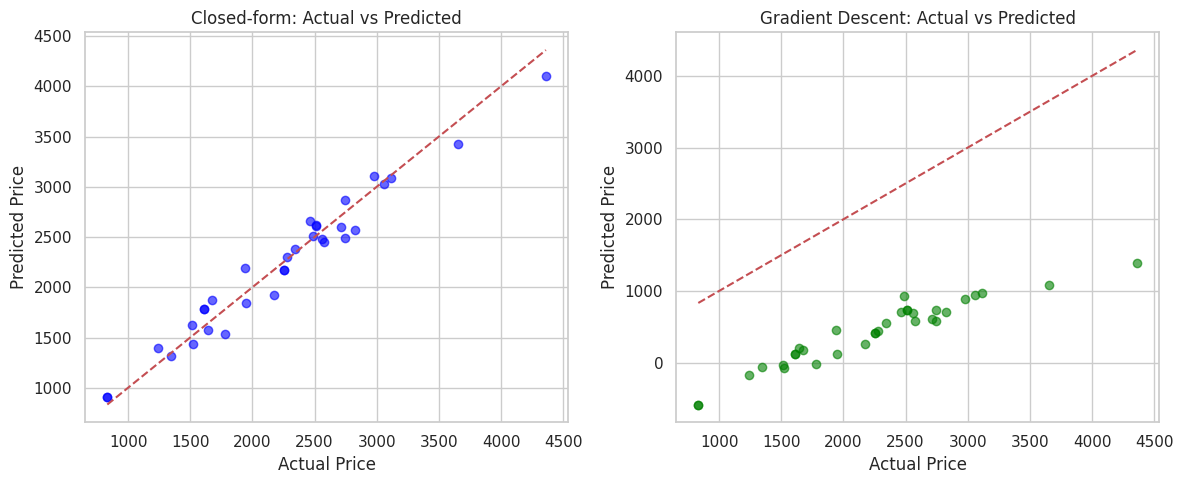

In [12]:
# --- 3) Plot Predicted vs Actual (No Regularization) ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_cf, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Closed-form: Actual vs Predicted')
plt.xlabel('Actual Price'); plt.ylabel('Predicted Price')

plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_gd, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Gradient Descent: Actual vs Predicted')
plt.xlabel('Actual Price'); plt.ylabel('Predicted Price')
plt.tight_layout()
plt.show()

In [13]:
# --- 4) Repeat with L2 Regularization (Ridge) ---
lambda_val = 1.0
theta_ridge_cf = normal_eqn(X_train_b, y_train, lmbda=lambda_val)
theta_ridge_gd = gradient_descent(X_train_b, y_train, alpha=1e-5, epochs=20000, lmbda=lambda_val)

y_pred_ridge_cf = X_test_b @ theta_ridge_cf
y_pred_ridge_gd = X_test_b @ theta_ridge_gd
mse_ridge_cf, rmse_ridge_cf, r2_ridge_cf = metrics(y_test, y_pred_ridge_cf)
mse_ridge_gd, rmse_ridge_gd, r2_ridge_gd = metrics(y_test, y_pred_ridge_gd)

print(f"\nRidge Closed-form → RMSE={rmse_ridge_cf:.3f}, R²={r2_ridge_cf:.3f}")
print(f"Ridge Gradient Descent → RMSE={rmse_ridge_gd:.3f}, R²={r2_ridge_gd:.3f}")



Ridge Closed-form → RMSE=152.494, R²=0.959
Ridge Gradient Descent → RMSE=1895.895, R²=-5.341


In [14]:
# --- 5) Compare Standardized vs Non-standardized ---
# (already standardized; now test without scaling)
X_train_b_raw = add_bias(X_train)
X_test_b_raw = add_bias(X_test)
theta_raw = normal_eqn(X_train_b_raw, y_train, lmbda=1.0)
y_pred_raw = X_test_b_raw @ theta_raw
_, rmse_raw, r2_raw = metrics(y_test, y_pred_raw)
print(f"\nWithout Standardization → RMSE={rmse_raw:.3f}, R²={r2_raw:.3f}")
print(f"With Standardization → RMSE={rmse_ridge_cf:.3f}, R²={r2_ridge_cf:.3f}")



Without Standardization → RMSE=152.011, R²=0.959
With Standardization → RMSE=152.494, R²=0.959


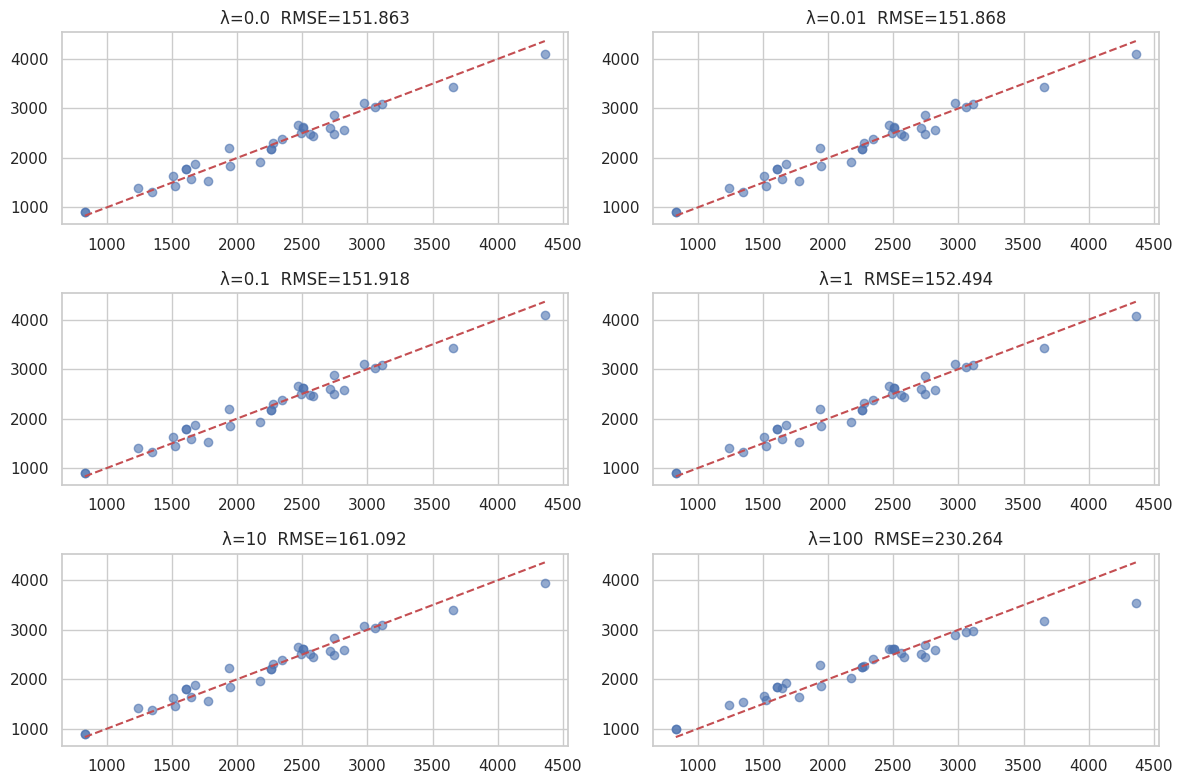

In [15]:
# --- 6) Plot Predicted vs Actual for different λ values ---
lambdas = [0.0, 0.01, 0.1, 1, 10, 100]
plt.figure(figsize=(12,8))
for i, lam in enumerate(lambdas):
    theta_tmp = normal_eqn(X_train_b, y_train, lmbda=lam)
    y_pred_tmp = X_test_b @ theta_tmp
    plt.subplot(3,2,i+1)
    plt.scatter(y_test, y_pred_tmp, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'λ={lam}  RMSE={np.sqrt(mean_squared_error(y_test, y_pred_tmp)):.3f}')
plt.tight_layout()
plt.show()



Top 10 Important Features:


,0
battery,167.764104
ram,162.837152
thickness,157.412005
internal mem,156.179290
ppi,152.088473
cpu core,121.328660
cpu freq,73.394720
weight,72.860199
resoloution,68.178626
Front_Cam,35.613308


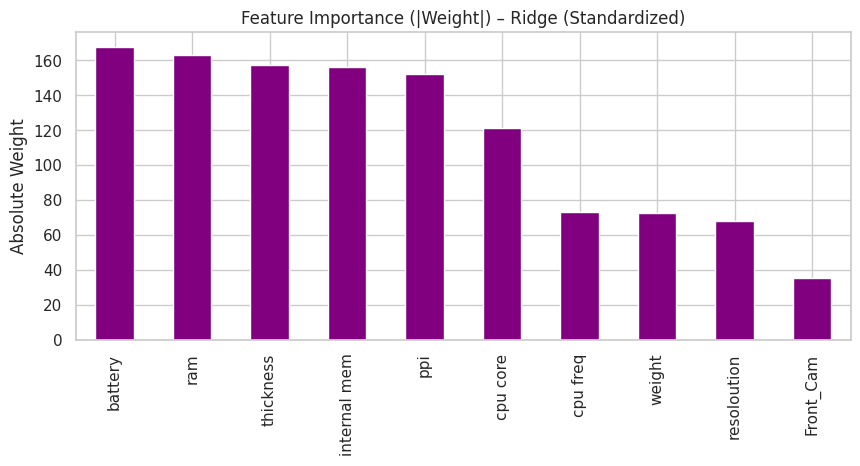

In [16]:
# --- 7) Feature Importance from L2 Weights ---
theta_final = normal_eqn(X_train_b, y_train, lmbda=1.0)
importance = pd.Series(np.abs(theta_final[1:]), index=features).sort_values(ascending=False)
print("\nTop 10 Important Features:")
display(importance.head(10))

importance.head(10).plot(kind='bar', figsize=(10,4), color='purple')
plt.title('Feature Importance (|Weight|) – Ridge (Standardized)')
plt.ylabel('Absolute Weight')
plt.show()

2. Linear Classification – Bank Note Authentication

In [17]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Import Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from mpl_toolkits.mplot3d import Axes3D

# --- Load Dataset ---
bank_path = '/content/drive/MyDrive/ML-THEO-ASS1/bank_dataset/BankNote_Authentication.csv'
bank = pd.read_csv(bank_path)

print("Dataset shape:", bank.shape)
display(bank.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset shape: (1372, 5)


,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


from matplotlib import pyplot as plt
_df_0['variance'].plot(kind='hist', bins=20, title='variance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['skewness'].plot(kind='hist', bins=20, title='skewness')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['curtosis'].plot(kind='hist', bins=20, title='curtosis')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['entropy'].plot(kind='hist', bins=20, title='entropy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='variance', y='skewness', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='skewness', y='curtosis', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='curtosis', y='entropy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['class']
  ys = series['variance']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('class', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('class')
_ = plt.ylabel('variance')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['class']
  ys = series['skewness']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('class', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('class')
_ = plt.ylabel('skewness')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['class']
  ys = series['curtosis']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('class', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('class')
_ = plt.ylabel('curtosis')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['class']
  ys = series['entropy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('class', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('class')
_ = plt.ylabel('entropy')

from matplotlib import pyplot as plt
_df_11['variance'].plot(kind='line', figsize=(8, 4), title='variance')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['skewness'].plot(kind='line', figsize=(8, 4), title='skewness')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['curtosis'].plot(kind='line', figsize=(8, 4), title='curtosis')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['entropy'].plot(kind='line', figsize=(8, 4), title='entropy')
plt.gca().spines[['top', 'right']].set_visible(False)

In [18]:
# --- Step 1: Divide dataset into train and test sets ---
print("Columns:", bank.columns.tolist())

target_col = 'class'
X = bank[[c for c in bank.columns if c != target_col]].values
y = bank[target_col].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# Standardize features for stability
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


Columns: ['variance', 'skewness', 'curtosis', 'entropy', 'class']
Training samples: 1097, Test samples: 275


In [20]:
# --- Step 2: Fit Logistic Regression with and without L2 regularization ---

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# ✅ Without regularization (use penalty=None for Colab compatibility)
clf_no_reg = LogisticRegression(penalty=None, solver='lbfgs', max_iter=5000)
clf_no_reg.fit(X_train_s, y_train)
acc_no_reg = accuracy_score(y_test, clf_no_reg.predict(X_test_s))

# ✅ With L2 regularization
clf_l2 = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=5000)
clf_l2.fit(X_train_s, y_train)
acc_l2 = accuracy_score(y_test, clf_l2.predict(X_test_s))

print(f"Accuracy (No Regularization): {acc_no_reg:.3f}")
print(f"Accuracy (With L2 Regularization): {acc_l2:.3f}")
print("\nClassification Report (L2 Regularization):")
print(classification_report(y_test, clf_l2.predict(X_test_s)))


Accuracy (No Regularization): 0.985
Accuracy (With L2 Regularization): 0.978

Classification Report (L2 Regularization):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       148
           1       0.97      0.98      0.98       127

    accuracy                           0.98       275
   macro avg       0.98      0.98      0.98       275
weighted avg       0.98      0.98      0.98       275



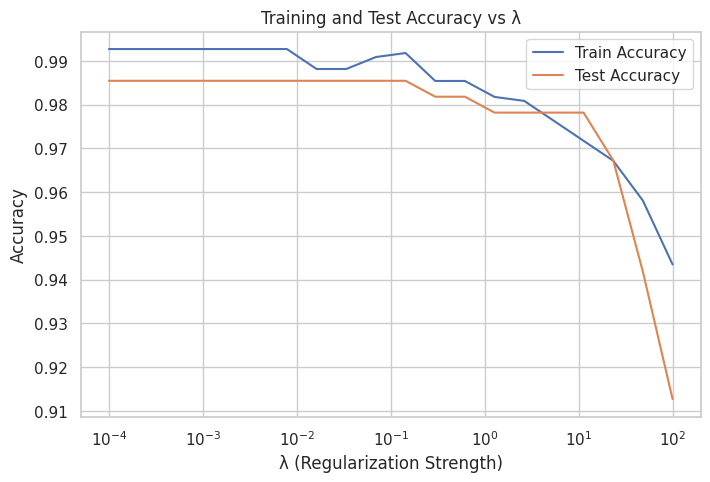

In [21]:
# --- Step 3: Plot training and test accuracy vs λ ---
lambdas = np.logspace(-4, 2, 20)
train_acc, test_acc = [], []

for lam in lambdas:
    C = 1.0 / lam
    clf = LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=5000)
    clf.fit(X_train_s, y_train)
    train_acc.append(clf.score(X_train_s, y_train))
    test_acc.append(clf.score(X_test_s, y_test))

plt.figure(figsize=(8,5))
plt.semilogx(lambdas, train_acc, label='Train Accuracy')
plt.semilogx(lambdas, test_acc, label='Test Accuracy')
plt.xlabel('λ (Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy vs λ')
plt.legend()
plt.grid(True)
plt.show()


Top 3 important features: ['curtosis', 'skewness', 'variance']


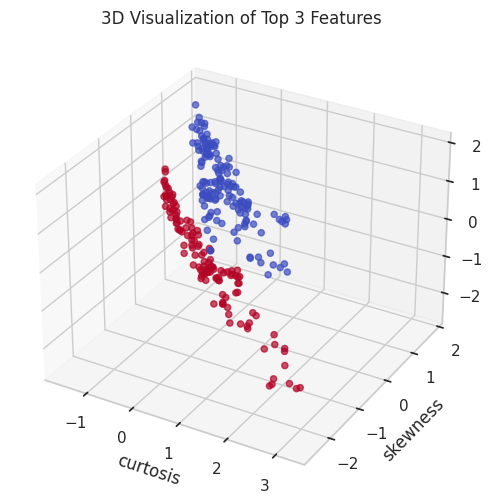

In [22]:
# --- Step 4: 3D Visualization using top 3 important features ---

coef_abs = np.abs(clf_l2.coef_[0])
feature_names = [c for c in bank.columns if c != target_col]
top3_idx = np.argsort(coef_abs)[-3:]
top3_names = [feature_names[i] for i in top3_idx]

print("Top 3 important features:", top3_names)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test_s[:, top3_idx[0]], X_test_s[:, top3_idx[1]], X_test_s[:, top3_idx[2]],
           c=y_test, cmap='coolwarm', alpha=0.7)
ax.set_xlabel(top3_names[0])
ax.set_ylabel(top3_names[1])
ax.set_zlabel(top3_names[2])
ax.set_title('3D Visualization of Top 3 Features')
plt.show()


In [25]:
# --- Step 5: Intentionally introduce stronger outliers ---
X_train_out = X_train_s.copy()

# Increase number and magnitude of outliers for clearer impact
n_outliers = int(0.1 * X_train_out.shape[0])   # 10% of training data
np.random.seed(42)
outlier_indices = np.random.choice(X_train_out.shape[0], n_outliers, replace=False)

# Shift multiple features heavily
X_train_out[outlier_indices, 0] += 30   # variance
X_train_out[outlier_indices, 1] -= 25   # skewness

print(f"Injected {n_outliers} strong outliers into first two features of training data.")


Injected 109 strong outliers into first two features of training data.



Accuracy before outliers: 0.978
Accuracy after outliers: 0.982

Top 5 features most affected by outliers:


,0
skewness,0.577249
variance,0.387563
entropy,0.255836
curtosis,0.200046


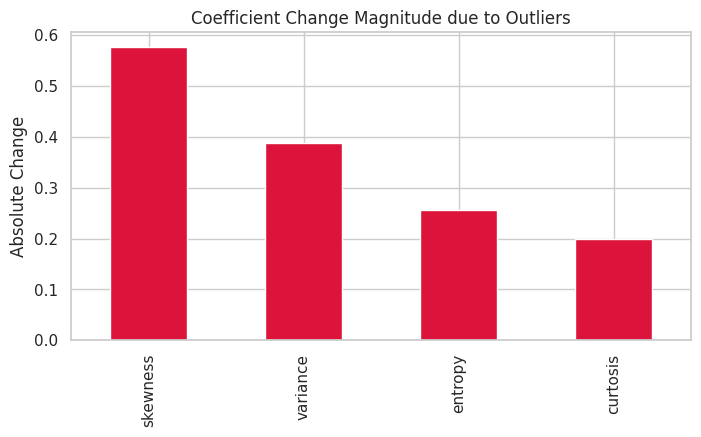

In [26]:
# --- Step 6: Fit classifier on outlier-injected data and comment on impact ---

clf_outlier = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=5000)
clf_outlier.fit(X_train_out, y_train)

acc_outlier = clf_outlier.score(X_test_s, y_test)

print(f"\nAccuracy before outliers: {acc_l2:.3f}")
print(f"Accuracy after outliers: {acc_outlier:.3f}")

# Compare coefficient change
coef_diff = clf_outlier.coef_ - clf_l2.coef_
change = pd.Series(np.abs(coef_diff[0]), index=feature_names).sort_values(ascending=False)
print("\nTop 5 features most affected by outliers:")
display(change.head(5))

# Plot coefficient changes
change.head(5).plot(kind='bar', color='crimson', figsize=(8,4))
plt.title('Coefficient Change Magnitude due to Outliers')
plt.ylabel('Absolute Change')
plt.show()
